## Compute lag features for gradient boosting model

In [536]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [464]:
colnames = ['id', 'ts', 'station_name', 'address', 'total_docks',
           'docks_in_service', 'available_docks', 'available_bikes',
           'percent_full', 'status', 'latitude', 'longitude', 'location', 'record']
docks_df = pd.read_csv('/Users/jordi/Downloads/chicago_docks.csv', names=colnames)

In [465]:
# drop unnecessary columns
docks_df = docks_df.drop(columns=['location', 'record'])

In [466]:
docks_df.head()

,id,ts,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,longitude
0,2,10/26/2018 11:55:13 AM,Buckingham Fountain,Buckingham Fountain,39,39,36,3,8,In Service,41.876470,-87.620340
1,3,10/26/2018 11:55:13 AM,Shedd Aquarium,Shedd Aquarium,55,54,50,4,7,In Service,41.867226,-87.615355
2,4,10/26/2018 11:55:13 AM,Burnham Harbor,Burnham Harbor,23,23,9,14,61,In Service,41.856268,-87.613348
3,5,10/26/2018 11:55:13 AM,State St & Harrison St,State St & Harrison St,23,22,20,2,9,In Service,41.874053,-87.627716
4,6,10/26/2018 11:55:13 AM,Dusable Harbor,Dusable Harbor,39,38,32,6,16,In Service,41.886976,-87.612813


In [467]:
docks_df.id.unique().shape

(615,)

In [468]:
stations_df = pd.read_csv('./datasets/chicago_stations.csv')

In [469]:
stations_df.head()

,Unnamed: 0,id,station_name,address,lat,lon
0,0,2,Buckingham Fountain,Buckingham Fountain,41.876470,-87.620340
1,1,3,Shedd Aquarium,Shedd Aquarium,41.867226,-87.615355
2,2,4,Burnham Harbor,Burnham Harbor,41.856268,-87.613348
3,3,5,State St & Harrison St,State St & Harrison St,41.874053,-87.627716
4,4,6,Dusable Harbor,Dusable Harbor,41.886976,-87.612813


In [470]:
stations_df.id.unique().shape

(615,)

In [471]:
station_ids = stations_df.id.unique()

## Preprocess at station level

In [561]:
station_id = station_ids[1]
df = docks_df[docks_df.id == station_id]
df['ts'] = pd.to_datetime(df.ts, infer_datetime_format=True)

In [562]:
df.ts.min(), df.ts.max()

(Timestamp('2017-01-01 00:05:11'), Timestamp('2018-10-26 11:55:13'))

In [563]:
# round ts every 5 minutes (seconds are not aligned)
df.loc[:, 'ts'] = df.ts.dt.round('5min')
df.sort_values(by='ts', inplace=True)

In [564]:
# resample data, there are missing info gaps
df = df.set_index('ts').resample('10Min', how='last', base=5).bfill()

In [565]:
# every hour we have 6 rows, one every 10 minutes
entries_per_hour = 6

In [566]:
# month of year
df['month'] = df.index.month
# quarter of year
df['quarter'] = df.index.quarter
# day of month
df['day'] = df.index.day
# hour of day
df['hour'] = df.index.hour
# quarter of hour
df['quarter_hour'] = np.floor(df.index.minute / 15)
# day of week
df['dow'] = df.index.dayofweek
# week of year
df['week'] = df.index.weekofyear

In [567]:
ab_daily_mean = df.groupby('day')['available_bikes'].mean()
ab_monthly_mean = df.groupby('month')['available_bikes'].mean()
ab_weekly_mean = df.groupby('week')['available_bikes'].mean()

In [568]:
for i, x in zip(ab_daily_mean.index, ab_daily_mean):
    df[df.day == i]['ab_daily_mean'] = x
    
for i, x in zip(ab_monthly_mean.index, ab_monthly_mean):
    df[df.month == i]['ab_montly_mean'] = x
    
for i, x in zip(ab_weekly_mean.index, ab_weekly_mean):
    df[df.week == i]['ab_weekly_mean'] = x

In [569]:
last_1w_hourly_mean = df.shift(entries_per_hour*24*7 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_1w_daily_mean = df.shift(entries_per_hour*24*7 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()
last_2w_hourly_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_2w_daily_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()

In [570]:
df['last_1w_hourly_mean'] = last_1w_hourly_mean
df['last_1w_daily_mean'] = last_1w_daily_mean
df['last_2w_hourly_mean'] = last_2w_hourly_mean
df['last_2w_daily_mean'] = last_2w_daily_mean

In [571]:
# set status to unknown when status is not available
df.loc[pd.isna(df.status), 'status'] = 'Unknown'

In [572]:
df

,id,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,...,quarter,day,hour,quarter_hour,dow,week,last_1w_hourly_mean,last_1w_daily_mean,last_2w_hourly_mean,last_2w_daily_mean
ts,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:05:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,0,0.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 00:15:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,0,1.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 00:25:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,0,1.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 00:35:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,0,2.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 00:45:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,0,3.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 00:55:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,0,3.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 01:05:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,1,0.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 01:15:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,1,1.0,6,52,NaN,NaN,NaN,NaN
2017-01-01 01:25:00,3.0,Shedd Aquarium,Shedd Aquarium,31.0,29.0,14.0,15.0,52.0,In Service,41.867226,...,1,1,1,1.0,6,52,NaN,NaN,NaN,NaN


### Set train/test splits

In [573]:
train_df = df.query('20170101 <= ts < 20181012')
test_df = df.query('ts >= 20181012')

In [574]:
train_df.shape, test_df.shape

((93456, 22), (2088, 22))

In [575]:
# overwrite last_1w_hourly_mean, last_1w_daily_mean columns for the second test week 
# this info is not available at test time!
idx = test_df.shift(freq=datetime.timedelta(weeks=1))[:entries_per_hour*24*7].index
features = ['last_1w_hourly_mean', 'last_1w_daily_mean']
test_df.loc[idx, features] = test_df.loc[idx - datetime.timedelta(weeks=1), features]

In [576]:
# drop first 2 weeks in train, no info for last_1w/2w features
train_df = train_df.iloc[entries_per_hour*24*7*2:]

In [577]:
train_df.shape, test_df.shape

((91440, 22), (2088, 22))

In [578]:
train_df.index.min(), train_df.index.max(), test_df.index.min(), test_df.index.max()

(Timestamp('2017-01-15 00:05:00', freq='10T'),
 Timestamp('2018-10-11 23:55:00', freq='10T'),
 Timestamp('2018-10-12 00:05:00', freq='10T'),
 Timestamp('2018-10-26 11:55:00', freq='10T'))

In [579]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

xs_features = ['total_docks', 'docks_in_service', 'available_docks', 'percent_full', 'status',
              'month', 'quarter', 'day', 'hour', 'quarter_hour', 'dow', 'week', 'last_1w_hourly_mean',
              'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean']
target = ['available_bikes']

le = LabelEncoder()
train_df['status'] = le.fit_transform(train_df['status'])
test_df['status'] = le.transform(test_df['status'])

train_data = lgb.Dataset(train_df[xs_features], label=train_df[target],
                        feature_name=xs_features, categorical_feature=['status'])
test_data = lgb.Dataset(test_df[xs_features], label=test_df[target],
                       feature_name=xs_features, categorical_feature=['status'])

In [580]:
test_df

,id,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,...,quarter,day,hour,quarter_hour,dow,week,last_1w_hourly_mean,last_1w_daily_mean,last_2w_hourly_mean,last_2w_daily_mean
ts,,,,,,,,,,,,,,,,,,,,,
2018-10-12 00:05:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,0,0.0,4,41,1.000000,2.312500,4.000000,5.986111
2018-10-12 00:15:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,0,1.0,4,41,1.000000,2.312500,4.000000,6.090278
2018-10-12 00:25:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,0,1.0,4,41,1.000000,2.312500,4.000000,6.194444
2018-10-12 00:35:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,0,2.0,4,41,1.000000,2.312500,4.000000,6.298611
2018-10-12 00:45:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,0,3.0,4,41,1.000000,2.312500,4.000000,6.402778
2018-10-12 00:55:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,0,3.0,4,41,1.000000,2.312500,4.000000,6.506944
2018-10-12 01:05:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,1,0.0,4,41,1.000000,2.312500,4.000000,6.611111
2018-10-12 01:15:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,1,1.0,4,41,1.000000,2.312500,4.000000,6.715278
2018-10-12 01:25:00,3.0,Shedd Aquarium,Shedd Aquarium,55.0,54.0,52.0,2.0,4.0,0,41.867226,...,4,12,1,1.0,4,41,1.000000,2.312500,4.000000,6.819444


In [581]:
params = {
    'objective': 'regression_l2',
    'num_threds': 4,
    'max_depth': 5,
}
bst = lgb.train(params, train_data, 10, valid_sets=[test_data])

[1]	valid_0's l2: 76.7248
[2]	valid_0's l2: 62.1814
[3]	valid_0's l2: 50.4216
[4]	valid_0's l2: 40.8969
[5]	valid_0's l2: 33.1406
[6]	valid_0's l2: 26.9103
[7]	valid_0's l2: 21.8176
[8]	valid_0's l2: 17.7153
[9]	valid_0's l2: 14.3864
[10]	valid_0's l2: 11.6758


In [582]:
y_true = test_df['available_bikes']
y_hat = bst.predict(test_df[xs_features])

In [583]:
np.sqrt(np.mean((y_true - y_hat)**2))

3.4169895275148097

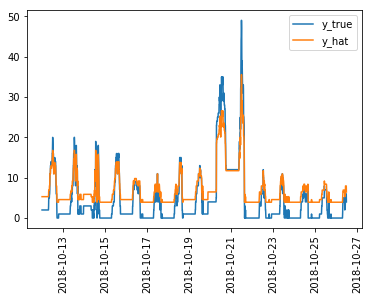

In [584]:
plt.plot(test_df.index, y_true, label='y_true')
plt.plot(test_df.index, y_hat, label='y_hat')
plt.xticks(rotation=90)
plt.legend()